In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb
import keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

2023-09-01 13:25:02.515219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:25:03.309986: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 13:25:03.449581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/li

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8584431366358344984
xla_global_id: -1
]


2023-09-01 13:25:09.899491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:25:09.932083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 13:25:09.932230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-09-01 13:25:0

# Generating and Visualizing the Dataset

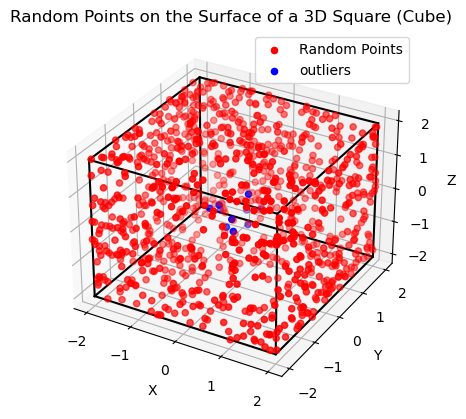

In [2]:
np.random.seed(0)

# Define the bounds of the 3D square (assuming a cube centered at the origin)
side_length = 4.0  # Adjust this as needed
x_min, x_max = -side_length / 2, side_length / 2
y_min, y_max = -side_length / 2, side_length / 2
z_min, z_max = -side_length / 2, side_length / 2

# Number of random points to generate
num_points = 1000  # Adjust this as needed

# Generate random points on the surface of the 3D square (cube)
random_points = []

for _ in range(num_points):
    axis = np.random.choice([0, 1, 2])  # Randomly select an axis (0 for x, 1 for y, 2 for z)
    sign = np.random.choice([-1, 1])   # Randomly select a sign (+1 or -1)

    if axis == 0:
        x = sign * side_length / 2
        y = np.random.uniform(y_min, y_max)
        z = np.random.uniform(z_min, z_max)
    elif axis == 1:
        x = np.random.uniform(x_min, x_max)
        y = sign * side_length / 2
        z = np.random.uniform(z_min, z_max)
    else:
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        z = sign * side_length / 2

    random_points.append([x, y, z])

# Convert the list of random points to a NumPy array for easier manipulation
random_points = np.array(random_points)

# Plot the cube and random points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the cube's faces
vertices = [
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
]

# Define the edges of the cube
cube_edges = [
    [vertices[0], vertices[1], vertices[2], vertices[3], vertices[0]],
    [vertices[4], vertices[5], vertices[6], vertices[7], vertices[4]],
    [vertices[0], vertices[4]],
    [vertices[1], vertices[5]],
    [vertices[2], vertices[6]],
    [vertices[3], vertices[7]]
]


num_points = 10  # Adjust this as needed

dim = 0.5
# Define the bounds for each axis
x_min, x_max = -dim, dim  # Adjust these bounds as needed
y_min, y_max = -dim, dim
z_min, z_max = -dim, dim

# Generate random 3D points within the specified bounds
outliers = np.random.uniform(low=(x_min, y_min, z_min), high=(x_max, y_max, z_max), size=(num_points, 3))


dataset = np.concatenate([random_points, outliers], axis = 0)

# Plot cube edges
for edge in cube_edges:
    ax.plot([v[0] for v in edge], [v[1] for v in edge], [v[2] for v in edge], 'k')

# Plot random points
ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2], c='r', marker='o', label='Random Points')
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], c='b', marker='o', label='outliers')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Random Points on the Surface of a 3D Square (Cube)')
ax.legend()
plt.show()

# Training the RAE

In [3]:
latent_dim = 5
num_dimensions = 3


encoder_inputs = keras.Input(shape=(num_dimensions,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(encoder_inputs)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(5, activation="relu")(x)
encoder_output = layers.Dense(latent_dim, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(5, activation="relu")(latent_inputs)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
# x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(num_dimensions, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class RAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.z_tracker = keras.metrics.Mean(name="z_loss")
        self.REG_tracker = keras.metrics.Mean(name="REG_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.z_tracker,
            self.REG_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            z_loss = K.mean(K.square(z), axis=[1])
    

#             gradients = tape.gradient(reconstruction, self.encoder(data))
    

#             gradient_norm = 0.0
#             for gradient in gradients:
#                 if gradient is not None:
#                     gradient_norm += tf.norm(gradient, ord=2)
    

            REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))

            total_loss = reconstruction_loss +  0.01 * z_loss + 0.01 * REG_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.z_tracker.update_state(z_loss)
        self.REG_tracker.update_state(REG_loss)
        del tape
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "z_loss": self.z_tracker.result(),
            "REG_loss": self.REG_tracker.result(),
        }
        

# mnist_data = mat_data['X']
tdata = np.concatenate([dataset], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

rae = RAE(encoder, decoder)
rae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = rae.fit(tdata, epochs=100, batch_size=1024)

2023-09-01 13:27:42.944963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 13:27:42.945051: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.1297 - reconstruction_loss: 2.1277 - z_loss: 0.1198 - REG_loss: 0.0751
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 2.1202 - reconstruction_loss: 2.1183 - z_loss: 0.1205 - REG_loss: 0.0747
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 2.1111 - reconstruction_loss: 2.1091 - z_loss: 0.1213 - REG_loss: 0.0749
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 2.1023 - reconstruction_loss: 2.1003 - z_loss: 0.1221 - REG_loss: 0.0754
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 2.0936 - reconstruction_loss: 2.0916 - z_loss: 0.1230 - REG_loss: 0.0763
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 2.0851 - reconstruction_loss: 2.0831 - z_loss: 0.1240 - REG_loss: 0.0775
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 2.0766 - reconstruction_loss: 2.0745 - z_loss: 0.1249 - REG_loss: 

1/1 [==============================] - 0s 3ms/step - loss: 1.7201 - reconstruction_loss: 1.7149 - z_loss: 0.2759 - REG_loss: 0.2473
Epoch 58/100
1/1 [==============================] - 0s 3ms/step - loss: 1.7143 - reconstruction_loss: 1.7091 - z_loss: 0.2795 - REG_loss: 0.2442
Epoch 59/100
1/1 [==============================] - 0s 3ms/step - loss: 1.7084 - reconstruction_loss: 1.7031 - z_loss: 0.2831 - REG_loss: 0.2426
Epoch 60/100
1/1 [==============================] - 0s 3ms/step - loss: 1.7023 - reconstruction_loss: 1.6970 - z_loss: 0.2868 - REG_loss: 0.2399
Epoch 61/100
1/1 [==============================] - 0s 2ms/step - loss: 1.6962 - reconstruction_loss: 1.6910 - z_loss: 0.2905 - REG_loss: 0.2363
Epoch 62/100
1/1 [==============================] - 0s 3ms/step - loss: 1.6900 - reconstruction_loss: 1.6847 - z_loss: 0.2943 - REG_loss: 0.2338
Epoch 63/100
1/1 [==============================] - 0s 3ms/step - loss: 1.6835 - reconstruction_loss: 1.6782 - z_loss: 0.2981 - REG_loss: 0.230